Files already downloaded and verified


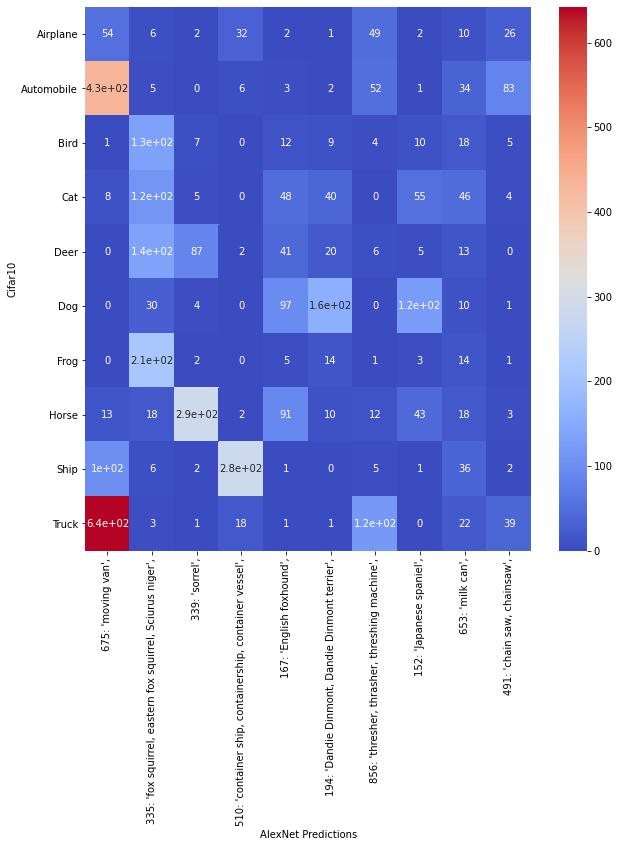

In [5]:
import torch
import torchvision
import tensorflow as tf
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from pathlib import Path
from torch.nn.functional import softmax
from keras.datasets import mnist, cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

with torch.no_grad():
    #get pretrained alexNet
    alexnet = models.alexnet(pretrained=True)

    # set transformations
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )])
    
    #get image test data and transform it to fit alexNet
    testData = datasets.CIFAR10(root = '.\data',train=False, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(testData, shuffle=True)

    #get imagenet classes and cifar10 classes
    cifar10Classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    with open('imageNetNames.txt') as f:
      classes = [line.strip() for line in f.readlines()]
    #put images from trainloader into model, colect top prediction and keep track of frequency of prediction output
    classCount = np.zeros(1000)
    predictions = torch.tensor([])
    labels = np.zeros(len(trainloader))
    count = 0
    for batch in trainloader:
        images, label = batch
        labels[count] = label
        alexnet.eval()
        output = alexnet(images)
        predictions = torch.cat((predictions, output),dim=0)
        _, predicted = torch.topk(output, 1)
        classCount[predicted] += 1
        count += 1
    mostFrequent = classCount.argsort()[-10:][::-1]
    mostFrequentClass = []
    labels = labels.astype(np.int64)
    labels = torch.from_numpy(labels).view(-1)
    #create list of most frequentClasses
    for element in mostFrequent:
        mostFrequentClass.append(classes[element])
        
    #combine predictions and cifar10 answers
    stack = torch.stack((labels,predictions.argmax(dim=1)),dim =1)

    #initialize confusion matrix go through each element in stack and if its a part of mostFrequentClass 
    #add one to matrix in position of that element and its prediction,
    confusionMatrix = np.zeros((10,10))
    for element in stack:
        first,second = element.tolist()
        if second in mostFrequent:
            confusionMatrix[first][np.where(mostFrequent == second)[0][0]] += 1
            
    #turn confusion matrix into heatmap and plot
    confusionMatrix = pd.DataFrame(confusionMatrix, index = [cifar10Classes],columns = [mostFrequentClass])
    plt.figure(figsize = (10,10))
    cMatrix = sns.heatmap(confusionMatrix, annot=True, cmap="coolwarm")
    plt.xlabel('AlexNet Predictions')
    plt.ylabel('Cifar10')
    
    

    
    
    